# Interpolation by factorized matrix completion

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{RX}||_2^2 + \mu ||\mathbf{X}||_*
$$

where $||\mathbf{X}||_*=\sum_i \sigma_i$ is the nuclear norm of $\mathbf{X}$ (i.e., sum of eigenvalues). We use the relaxed version:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2 + \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2
$$

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Restriction operator
n, m, k = 200, 100, 10
sub = 0.4
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]

Rop = Restriction(n*m, iava)

In [36]:
# model
U = np.random.normal(0., 1., (n, k))
V = np.random.normal(0., 1., (m, k))

X = U @ V.T

# data
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(n, m)

In [37]:
X = U @ V.T
X1 = (V @ U.T).T

## U V^T as linear operator (with V as model)

$$
\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_u(\mathbf{v})
$$

In [38]:
Uop = MatrixMult(U, dims=(m,))
Top = Transpose((m,k), (1,0))
print(Uop, Top)
X1 = (Uop * Top) * V.ravel()
X1 = X1.reshape(n,m)
print(X-X1)

# data
Ruop = Rop * Uop * Top
y1 = Ruop * V.ravel()
print(y-y1)

<20000x1000 MatrixMult with dtype=float64> <1000x1000 Transpose with dtype=float64>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.]


## U V^T as linear operator (with U as model

$$
\mathbf{y}=\mathbf{R}\mathbf{U}\mathbf{V}^T = R_v(\mathbf{u})
$$

In [39]:
Vop = MatrixMult(V, dims=(n,))
Top = Transpose((n,k), (1,0))
T1op = Transpose((n,m), (1,0))

X1 = (T1op.T * Vop * Top) * U.ravel()
X1 = X1.reshape(n,m)
print(X-X1)

# data
Ruop = Rop * T1op.T * Vop * Top
y1 = Ruop * U.ravel()
print(y-y1)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.77635684e-15
   0.00000000e+00  4.44089210e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.22044605e-16  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[0. 0. 0. ... 0. 0. 0.]


## Factorized Matrix completion with a proximal solver

Adapted from *Alg2 in Practical Large-Scale Optimization for Max-Norm Regularization*.

Let's consider the following functional composed of a sum of a smooth term f(x) and a non-smooth one g(x)

$$
arg \;  min_\mathbf{X} f(x)+g(x)
$$

we define the overall model vector $x = [u, v]$, $f=\frac{1}{2}||\mathbf{y}-\mathbf{R}(\mathbf{U}\mathbf{V}^T)||_2^2$  and $g= \mu ||\mathbf{U}||_F^2+ \mu ||\mathbf{V}||_F^2$ (which is the sum of partial elements of x so the proximal is just the vertical stack of their proximals.

Now we can write our iteration as:

$$
x^{k+1} = prox_{\mu\tau^kg} (x^{k} - \tau^k \nabla f)
$$

where $\nabla f = [\nabla f_u, \nabla f_v] = [R_v^T(R_v u^k -y), R_u^T(R_u v^k -y)]$ ans the proximal of the Frobenious norm ($prox_g$)is as simple as that of the L2 squared norm of the vector x.

In [42]:
import numpy as np
from pylops import LinearOperator
from pylops.utils.backend import get_array_module, to_cupy_conditional


class FactorizedSVD(LinearOperator):
    r"""Factorized SVD operator.
    
    Given a matrix X=U V^T creates X from vectorized V and U

    """
    def __init__(self, U, V, dtype='float64'):
        n, k = U.shape
        m = V.shape[0]
        
        # V as model
        self.Uop = MatrixMult(U, dims=(m,))
        self.VTop = Transpose((m,k), (1,0))
        self.Utotop = self.Uop * self.VTop
        
        # U as model
        self.Vop = MatrixMult(V, dims=(n,))
        self.UTop = Transpose((n,k), (1,0))
        self.XTop = Transpose((n,m), (1,0))
        self.Vtotop = (self.XTop.T * self.Vop * self.UTop)
        
        # stacked
        self.Op = BlockDiag([self.Utotop, self.Vtotop])
        self.shape = (2*n*m, k*(n+m))
        self.dtype = np.dtype(dtype)
        self.explicit = False
        
    def update(self, U, V):
        self.Uop.A = U
        self.Vop.A = V
        
    def _matvec(self, x):
        return self.Op.matvec(x)

    def _rmatvec(self, x):
        return self.Op.rmatvec(x)

In [43]:
Fop = FactorizedSVD(U,V)
uv = np.hstack([V.ravel(), U.ravel()])

X2 = Fop * uv

In [44]:
X2[:n*m].reshape(n, m)-X, X2[n*m:].reshape(n, m)-X

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  2.22044605e-16],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.77635684e-15,  0.00000000e+00, -4.44089210e-16],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  2.22044605e-16,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  2.22044605e-16,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, 

In [70]:
# check gradients with formulas in https://link.springer.com/content/pdf/10.1007/s10107-013-0701-9.pdf p.486
Y = np.random.normal(0, 1, (n, m))
y = Y.flatten()

grad_U = (U @ V.T - Y) @ V
grad_V = U.T @ (U @ V.T - Y)

grad_VU = - Fop.H @ (np.hstack([y,y]) - Fop @ uv)

In [71]:
np.hstack([grad_V.ravel(), grad_U.ravel()]) - grad_VU

array([  0.        , 296.13025151, 227.17868518, ...,   0.        ,
         0.        ,   0.        ])

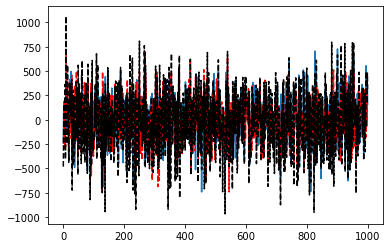

In [82]:
plt.plot(grad_V.ravel()) 
plt.plot(grad_VU[:m*k], '--r')
plt.plot(grad_V.ravel()+grad_VU[:m*k], '--k')

In [12]:
Op = BlockDiag([Rop, Rop]) * Fop

y2 = Op * uv
y2[:nsub]- y, y2[nsub:]- y

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [15]:
Uest = np.random.normal(0., 1., (n, k))
Vest = np.random.normal(0., 1., (m, k))

uvest = np.hstack([Vest.ravel(), Uest.ravel()])

grad = Op.H * (np.hstack([y,y])-Op*uvest)

In [14]:
# Check update
Fop = FactorizedSVD(U,V)
uv = np.hstack([V.ravel(), U.ravel()])
X2 = Fop * uv

Fop.update(U*0, -V)
X2_ = Fop * uv
X2[:m*n], X2_[:m*n], X2[m*n:], X2_[m*n:]

<20000x1000 LinearOperator with dtype=float64> <20000x2000 LinearOperator with dtype=float64>


(array([ 0.54680969,  2.50202984,  2.36774743, ..., -2.2650825 ,
         6.11961994, -0.43279361]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.54680969,  2.50202984,  2.36774743, ..., -2.2650825 ,
         6.11961994, -0.43279361]),
 array([-0.54680969, -2.50202984, -2.36774743, ...,  2.2650825 ,
        -6.11961994,  0.43279361]))

In [13]:
# model
U = np.random.normal(0., 1., (n, k))
V = np.random.normal(0., 1., (m, k))

X = U @ V.T

# data
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(n, m)

In [14]:
niter=1

mu = 0.2
l2 = L2(sigma=mu)
Uest0 = U+np.random.normal(0., .3, (n, k))
Vest0 = V+np.random.normal(0., .3, (m, k))
uest, vest = Uest0.flatten(), Vest0.flatten()
x = np.hstack([vest, uest])

gamma=0.5
tau = 1e-3
for i in range(niter):
    # compute gradient
    Vest, Uest = x[:m*k].reshape(m,k), x[m*k:].reshape(n,k)
    Fop.update(Uest, Vest)
    xnew = x + tau * Op.H * (np.hstack([y,y])-Op*uvest)
    # compute proximal of frobenious 
    xnew = l2.prox(xnew, tau)
    # Armijio
    # TO DO!
    # Update
    x = (1-gamma**l)*x + gamma**l * xnew

NameError: name 'l' is not defined

In [ ]:
Vest, Uest = x[:m*k].reshape(m,k), x[m*k:].reshape(n,k)
Xest = Uest @ Vest.T

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(10,10))
plt.imshow(Xest, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(10,10))
plt.imshow(X-Xest, vmin=-5, vmax=5)
plt.axis('tight')

In [ ]:
plt.figure(figsize=(3,10))
plt.imshow(U, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(3,10))
plt.imshow(Uest, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(3,10))
plt.imshow(U-Uest, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(3,10))
plt.imshow(V, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(3,10))
plt.imshow(Vest, vmin=-5, vmax=5)
plt.axis('tight')

plt.figure(figsize=(3,10))
plt.imshow(V-Vest, vmin=-5, vmax=5)
plt.axis('tight')

## TO DO:

- Check if update function in FactorizedSVD works
- Need to finalize Alg2 by finding gamma...